This code plots the bootstrapped partial dependence plots

In [1]:
# import libraries
library(data.table)
library(ggplot2)
library(ggthemes)
library(gridExtra)
library(extrafont)

Warning message:
"package 'data.table' was built under R version 3.4.4"Warning message:
"package 'ggplot2' was built under R version 3.4.4"Warning message:
"package 'ggthemes' was built under R version 3.4.4"Warning message:
"package 'gridExtra' was built under R version 3.4.4"Warning message:
"package 'extrafont' was built under R version 3.4.4"Registering fonts with R


In [2]:
cbbPalette <- c('pink',"#E69F00", "#009E73", "#0072B2", "#56B4E9", "#CC79A7", "#D55E00", "#F0E442")

In [3]:
grid.size <- 500

In [4]:
# import the data
dt = fread(paste0('../../data/regression/results_partial_dependents_', grid.size, '.csv'))

# import raw data for the histograms
df = fread(paste0('../../data/data_regressions_', grid.size,'_20190405_unnormalized.csv'))

# Plot the PDPs

In [5]:
plots <- list()
ncol.plot <- 5
# xlims <- c(0,30)

In [6]:
# import the feature order
if (grid.size == 500){
    features = c('tree_mean', 'ndvi_mean', 'lcov_11', 'svf_mean', 'dsm_mean', 'alb_mean', 'tree_max', 'nbdi_max', 'bldg', 'pdens_mean')
    } else {
    features = c('tree_mean', 'ndvi_mean', 'lcov_11', 'svf_mean', 'dsm_mean', 'alb_mean', 'tree_sd', 'nbdi_sd_sl', 'bldg', 'pdens_mean')
#     features = c('tree_mean', 'ndvi_mean', 'alb_mean', 'svf_mean', 'dsm_mean', 'tree_max', 'nbdi_max', 'bldg', 'pdens_mean', 'lcov_11')
}

In [7]:
feature_names <- c('lcov_11' = '% water','tree_mean'='% tree canopy','ndvi_mean'='ndvi','svf_mean'='sky view factor',
                    'dsm_mean'='digital surface model','alb_mean'='albedo','dsm_sd'='dsm stand. dev.','nbdi_max'='max nbdi',
                    'tree_max'='max % tree can.','bldg'='% building area','pdens_mean'='pop. density',
                    'tree_sd'= '% tree can. stand. dev.', 'nbdi_sd_sl'='nbdi surrounding stand. dev.',
                    'tree_sd_sl'='% tree can. surrounding stand. dev.',
                    'ndvi_sd'= 'ndvi stand. dev'   )

In [8]:
# calculate the histogram for each of the features
# df_hist <- df[density_housesarea > xlims[1] & density_housesarea < xlims[2],]

In [9]:
head(dt)

V1,Unnamed: 0,boot,dependent,independent,mean,model,x
0,0,1,lst_day_mean,ndvi_mean,1.632176,gbrt,0.04715931
1,1,1,lst_day_mean,ndvi_mean,1.144977,rf,0.04715931
2,2,1,lst_day_mean,ndvi_mean,3.184495,mars,0.04715931
3,3,1,lst_day_mean,ndvi_mean,2.915183,gam,0.04715931
4,4,1,lst_day_mean,ndvi_mean,3.691440,mlr,0.04715931
5,5,1,lst_day_mean,ndvi_mean,1.776883,gbrt,0.06189401


In [10]:
if (grid.size == 500){
    hist_scaling <- c(20, 0.8, 12, 0.35, 400, 200, 30, 0.7, 60, 7000)
    } else {
    hist_scaling <- c(35, 0.9, 1.3, 0.45, 400, 
                      250, 10, 0.15, 35, 6000)
}

In [11]:
font.size <- 15

In [12]:
# determine the axis limits
y_min <- -8#round(min(dt[,'mean'])*2)/2
y_max <- 5#round(max(dt[,'mean'])*2)/2
ylims <- c(y_min,y_max) - y_min

dt_sub <- dt[dependent == 'lst_night_mean',]

for (i in seq(10)){
    var <- features[[i]]
    # subset the dataframe 
    dt_plot <- dt_sub[independent == var,]
    xlims <- c(min(dt_plot[,x]), max(dt_plot[,x])) + max(dt_plot[,x])*c(-0.05,0.05)
    # plot the lines
    plt <- ggplot(dt_plot,aes(x = x, y = mean - y_min, color = model)) +
        geom_line(aes(group = interaction(model, boot)), alpha = 0.3) +
        geom_hline(yintercept = -y_min, linetype="dashed", color = "red") + 
        xlab(feature_names[var]) + 
        ylab('') + 
        scale_colour_manual(values=cbbPalette) + 
        theme_few()  + 
        theme(text=element_text(size=font.size, family="Corbel"),
              legend.title = element_blank(),
              legend.position="none", 
              plot.title = element_text(size = font.size)
             ) + 
        guides(color = guide_legend(override.aes= list(alpha = 1))) +
        scale_y_continuous(breaks = c(seq(ylims[1], ylims[2],length = 5),-y_min), labels= c(seq(y_min,y_max,length = 5),0)) 
        if (i == 1 || i==6){
            plt <- plt + ylab(expression("change in "*~degree*C)) 
            }
#         ggtitle(health_titles[var]) + 
#         theme_black() +
#     if (i == 8){
#         plt <- plt + theme(text=element_text(size=10),
#               legend.title = element_blank(),
#               legend.position="none", 
#               plot.title = element_text(size = 10)
#              )
#         }
    # plot the histogram
    df_hist <- df[as.vector((df[, ..var] >= xlims[1]) & (df[,..var] <= xlims[2])),]
    plt <- plt + geom_histogram(data=df_hist, bins=30, mapping=aes_string(var, paste0('..density..*',hist_scaling[i])), color = 'black', alpha = 0.5)
    plt <- plt + coord_cartesian(ylim=ylims, xlim=xlims, expand=0)  
    # add to list
    plots[[i]] <- plt
#     ggsave('../../fig/report/pdp_uncert_night.png', plt, width=17.8/2.54, height=11.5/2.54)
    }

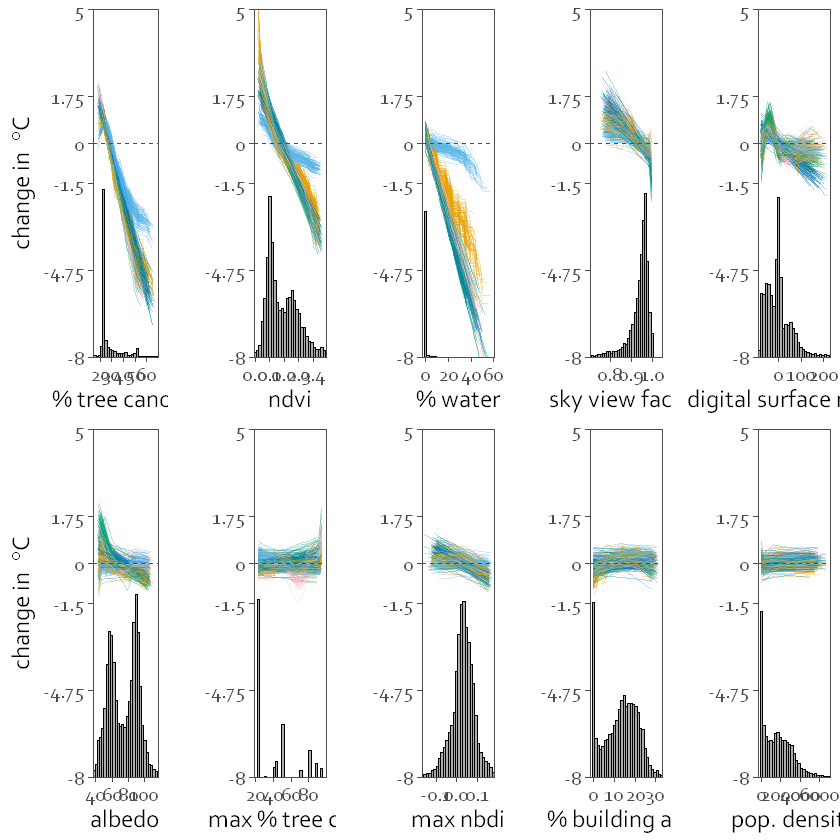

In [13]:
plots.grid <- do.call("grid.arrange", c(plots, ncol=ncol.plot))
outname <- paste0('../../fig/report/pdp_uncert_night_',grid.size,'.png')
ggsave(outname, plots.grid, width=17.8, height=7, dpi=500)

In [14]:
# determine the axis limits
y_min <- -8#round(min(dt[,'mean'])*2)/2
y_max <- 5#round(max(dt[,'mean'])*2)/2
ylims <- c(y_min,y_max) - y_min

dt_sub <- dt[dependent == 'lst_day_mean',]

for (i in seq(10)){
    var <- features[[i]]
    # subset the dataframe 
    dt_plot <- dt_sub[independent == var,]
    xlims <- c(min(dt_plot[,x]), max(dt_plot[,x])) + max(dt_plot[,x])*c(-0.05,0.05)
    # plot the lines
    plt <- ggplot(dt_plot,aes(x = x, y = mean - y_min, color = model)) +
        geom_line(aes(group = interaction(model, boot)), alpha = 0.3) +
        geom_hline(yintercept = -y_min, linetype="dashed", color = "red") + 
        xlab(feature_names[var]) + 
        ylab('') + 
        scale_colour_manual(values=cbbPalette) + 
        theme_few()  + 
        theme(text=element_text(size=font.size, family="Corbel"),
              legend.title = element_blank(),
              legend.position="none", 
              plot.title = element_text(size = font.size)
             ) + 
        guides(color = guide_legend(override.aes= list(alpha = 1))) +
        scale_y_continuous(breaks = c(seq(ylims[1], ylims[2],length = 5),-y_min), labels= c(seq(y_min,y_max,length = 5),0)) 
        if (i == 1 || i==6){
            plt <- plt + ylab(expression("change in "*~degree*C)) 
            }
#         ggtitle(health_titles[var]) + 
#         theme_black() +
#     if (i == 8){
#         plt <- plt + theme(text=element_text(size=10),
#               legend.title = element_blank(),
#               legend.position="none", 
#               plot.title = element_text(size = 10)
#              )
#         }
    # plot the histogram
    df_hist <- df[as.vector((df[, ..var] >= xlims[1]) & (df[,..var] <= xlims[2])),]
    plt <- plt + geom_histogram(data=df_hist, bins=30, mapping=aes_string(var, paste0('..density..*',hist_scaling[i])), color = 'black', alpha = 0.5)
    plt <- plt + coord_cartesian(ylim=ylims, xlim=xlims, expand=0)  
    # add to list
    plots[[i]] <- plt
#     ggsave('../../fig/report/pdp_uncert_day.png', plt, width=17.8/2.54, height=11.5/2.54)
    }

In [ ]:
plots.grid <- do.call("grid.arrange", c(plots, ncol=ncol.plot))
outname <- paste0('../../fig/report/pdp_uncert_day_',grid.size,'.png')
ggsave(outname, plots.grid, width=17.8, height=7, dpi=500)